In [1]:
import xarray
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from pyecharts import options as opts
from pyecharts.charts import Geo, Scatter
from pyecharts.globals import ChartType, SymbolType


In [9]:
def generate_daily_dates(start_time, end_time):
    start_datetime = datetime.strptime(start_time, '%Y%m%d')
    end_datetime = datetime.strptime(end_time, '%Y%m%d')

    date_sequence = []
    current_datetime = start_datetime 
    while current_datetime <= end_datetime:
        date_sequence.append(datetime.strftime(current_datetime, '%Y%m%d'))
        current_datetime += timedelta(days=1)

    return date_sequence




In [58]:
df = xarray.open_dataset("/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/code/station/1001A.nc")
df

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 730, hour: 24)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2018-01-01 2018-01-02 ... 2019-12-31
  * hour       (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
Data variables: (12/15)
    AQI        (time, hour) float64 140kB ...
    PM2.5      (time, hour) float64 140kB ...
    PM2.5_24h  (time, hour) float64 140kB ...
    PM10       (time, hour) float64 140kB ...
    PM10_24h   (time, hour) float64 140kB ...
    SO2        (time, hour) float64 140kB ...
    ...         ...
    O3         (time, hour) float64 140kB ...
    O3_24h     (time, hour) float64 140kB ...
    O3_8h      (time, hour) float64 140kB ...
    O3_8h_24h  (time, hour) float64 140kB ...
    CO         (time, hour) float64 140kB ...
    CO_24h     (time, hour) float64 140kB ...

In [20]:
nan_count = df.isnull().sum()/(len(df['time']) * len(df['hour']))



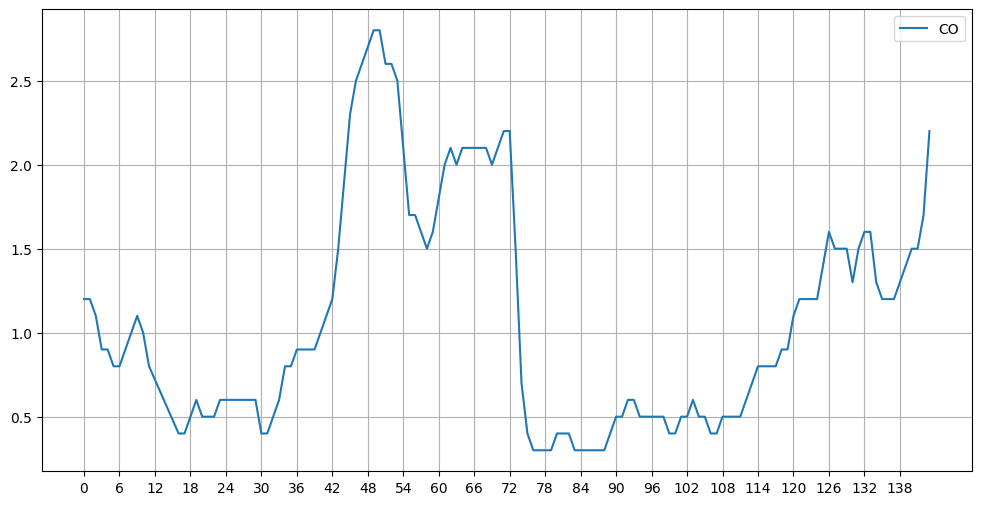

<xarray.Dataset> Size: 18kB
Dimensions:    (time: 6, hour: 24)
Coordinates:
  * time       (time) datetime64[ns] 48B 2019-01-01 2019-01-02 ... 2019-01-06
  * hour       (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
Data variables: (12/15)
    AQI        (time, hour) float64 1kB 73.0 73.0 68.0 ... 138.0 139.0 133.0
    PM2.5      (time, hour) float64 1kB 53.0 53.0 49.0 ... 105.0 106.0 101.0
    PM2.5_24h  (time, hour) float64 1kB 44.0 44.0 44.0 44.0 ... 70.0 73.0 76.0
    PM10       (time, hour) float64 1kB 76.0 75.0 70.0 ... 131.0 125.0 143.0
    PM10_24h   (time, hour) float64 1kB 68.0 69.0 68.0 ... 104.0 107.0 109.0
    SO2        (time, hour) float64 1kB 15.0 14.0 9.0 8.0 ... 15.0 14.0 30.0
    ...         ...
    O3         (time, hour) float64 1kB nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    O3_24h     (time, hour) float64 1kB 26.0 26.0 26.0 26.0 ... 20.0 20.0 20.0
    O3_8h      (time, hour) float64 1kB nan nan nan nan nan ... 8.0 8.0 5.0 3.0
    O3_8h_24h  (time, hour) float64 1kB 16.0 14.33 12.67 11.0 ... 10.0 10.0 10.0
    CO         (time, hour) float64 1kB 1.2 1.2 1.1 0.9 0.9 ... 1.5 1.5 1.7 2.2
    CO_24h     (time, hour) float64 1kB 1.0 1.1 1.0 1.0 1.0 ... 1.3 1.3 1.4 1.4

In [59]:
'''
nearest: 使用最近的有效值进行插值。
zero: 阶梯插值。
slinear: 线性插值，与 linear 类似。
quadratic: 二次插值。
cubic: 三次插值。
polynomial: 多项式插值，可以指定 order 参数来控制多项式的阶数。
spline: 样条插值，可以通过 order 参数指定样条的阶数。
barycentric: 重心插值。
krog: Kriging 插值，适用于不规则网格。
pchip: 分段三次 Hermite 多项式插值。
akima: Akima 插值，用于不规则数据。
'''
ds_ins = df.interpolate_na(dim='hour', method='slinear')
start_time = pd.Timestamp('2019-01-01 00:00:00')
# end_time  = start_time + pd.Timedelta(hours=144)
# print(end_time)
time_list = [start_time + pd.Timedelta(days = h) for h in range(0,6)]
ds_fore = ds_ins.sel(time = time_list)
steps = range(0,144)
plt.figure(figsize=(12, 6))
plt.plot(range(0,144),ds_fore['CO'].values.flatten(), label='CO')
plt.xticks(range(0,144,6))
plt.grid(True)
plt.legend()
plt.show()
ds_fore

缺失值处理
对于缺失值常用的几种处理方式有：

* 删除缺失值：仅适用于缺失数量很少的情况  
填充缺失值：
数值变量：
   * 均值填充 ：mean
   * 中值填充 ：median
类别变量：
   * 众数填充 ：mode
   * 单独作为一个类别

* 其他填充方法：
   * 前向填充：ffill
   * 后向填充：bfill
   * 常值填充

缺失数据填补法细分为替换缺失值、拟合缺失值以及多重插补法三种  
替换缺失值的方法又名简单填充法，是一种常见且易行的缺失值填补方式    
1）使用均值、中位数或众数。当数据为数值型时，可以采用均值或众数填充  
2）热卡填充法，也称就近补齐法，它是一种使用缺失记录最相似的记录对其进行填补的方法，热卡填充法可以视为一种特殊的 KNN 方法。与 KNN 算法相同，相似性的定义方法直接影响了热卡填充法的性能  
3)拟合法主要包含对缺失值进行回归预测、随机森林预测以及极大似然估计等方法。回归预测法主要是根据数据集中的已有数据训练回归模型，而后使用该模型对缺失值进行预测，仅适用于变量之间存在线性关系的情况  
4)多重插补法是指通过已观测数据建立多个插值函数并用它们分别估计待插补值，这样就形成了多个模拟数据集。在选择最佳插补值时，考虑使模型评分最高的数据集对应的插补方法。


* 异常值检测
  * 箱形图
  * 3σ原则

In [23]:
# df = data 
# # 缺失率
# nan_count = df.isnull().sum() / ( len(data['hour']) * len(data['time']) )
# for var in nan_count.variables:
#     print(f"{var} : {nan_count[var].values * 100:.2f}%")

* 异常值检测 
  * 3σ方式
  * 使用箱线图辅助
  * 相关异常检测算法

In [9]:
# plt.figure(figsize=(10, 5))
# plt.plot(AQI['hour'], AQI['O3'], marker='o', label='Daily Mean AQI')
# plt.xticks(AQI['hour'])
# plt.xlabel('hour')
# plt.ylabel('Value')
# plt.title('Daily Mean O3  in 2019')
# plt.legend()
# plt.grid(True)

In [53]:
import pandas as pd
from pyecharts.charts import Geo
from pyecharts import options as opts
from pyecharts.globals import SymbolType

# 读取数据
data = pd.read_csv('./station/station_name.csv')

# 提取经纬度数据并用城市作为名称
locations = [
    [city, lng, lat]
    for city, lng, lat in zip(data['监测点编码'], data['经度'], data['纬度'])
]


# 提取站点名称和对应的比率
data_pair = [(city, 1) for city, lng, lat in locations ]

# 创建 Geo 图表
geo = Geo()
geo.add_schema(maptype="china")
# 添加自定义坐标
for key, lng, lat in locations:
    geo.add_coordinate(key, lng, lat)

# 添加数据点
geo.add('', data_pair, symbol_size=7, itemstyle_opts=opts.ItemStyleOpts(color="blue"))

# 配置系列选项和全局选项
geo.set_series_opts(label_opts=opts.LabelOpts(is_show=False), type='scatter')
geo.set_global_opts(
    visualmap_opts=opts.VisualMapOpts(max_=1),  
    title_opts=opts.TitleOpts(title="站点分布")  
)


# 渲染或展示图表
geo.render_notebook()


In [ ]:
# 2014_to_2022_China_Station_APL_Data/Data/_#U7ad9#U70b9#U5217#U8868/#U7ad9#U70b9#U5217#U8868-2022.02.13#U8d77.csv

2037
2028


2037